# Expe 1, noise tagging condition, synthetic data with 10% tag, individual analysis of participant A0

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A0/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/data/A0/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_0.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'PO3', 'POz', 'P3', 'P7', 'P5']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, bin_to_dataframe

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_13926/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


## 1. 10% injected noise

In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 451 samples (0.220 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s


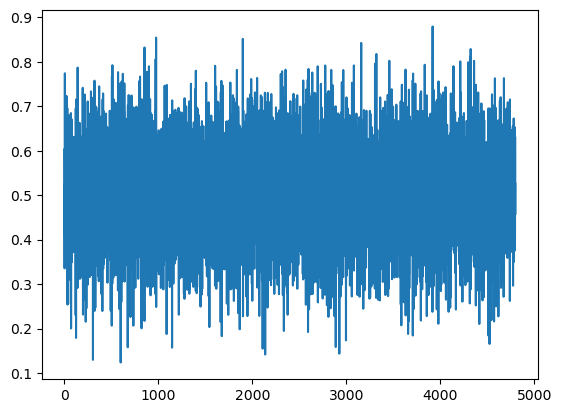

In [6]:
# First noise tag at block 15 trial 32
plt.plot((noise_stims[14,31,0,:].T+noise_stims[14,31,1,:].T)/2)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [7]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [8]:
noise_stims_tr.shape

(480, 2, 4800)

### Inject cued tags to EEG

In [9]:
epochs_noistag.resample(480)
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']) :
    offset = int(np.random.normal(.2, .025)*epochs_noistag.info['sfreq'])#np.random.randint(int(.1*epochs_noistag.info['sfreq']), int(.125*epochs_noistag.info['sfreq']))
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Select the tag that was projected during the trial
    injected_tag = noise_stims_tr[trial, cued_side, \
        :int((np.abs(epochs_noistag.tmax))*epochs_noistag.info['sfreq'])-offset+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.111111#0.01010101
    # Add the tag to the EEG
    buffer_arr[idx,:,int((np.abs(epochs_noistag.tmin))*epochs_noistag.info['sfreq'])+offset:] += injected_tag
epochs_noistag._data = buffer_arr


/tmp/ipykernel_13926/195207739.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_13926/195207739.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


### Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.


Text(0, 0.5, 'Cor EEG/tag')

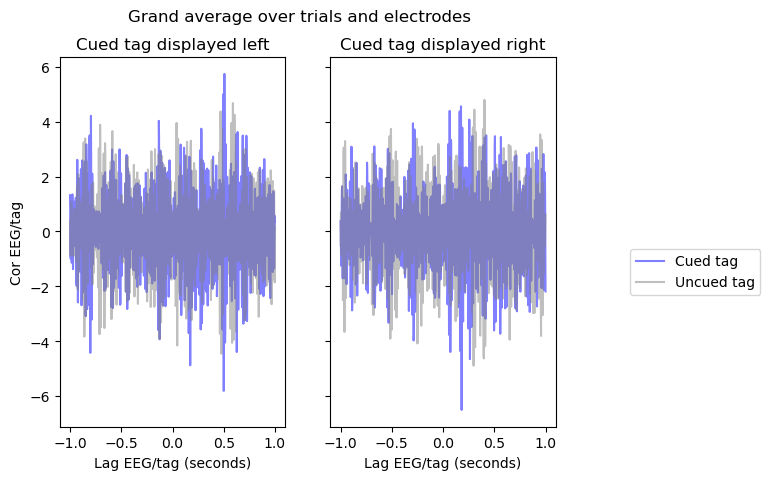

In [10]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

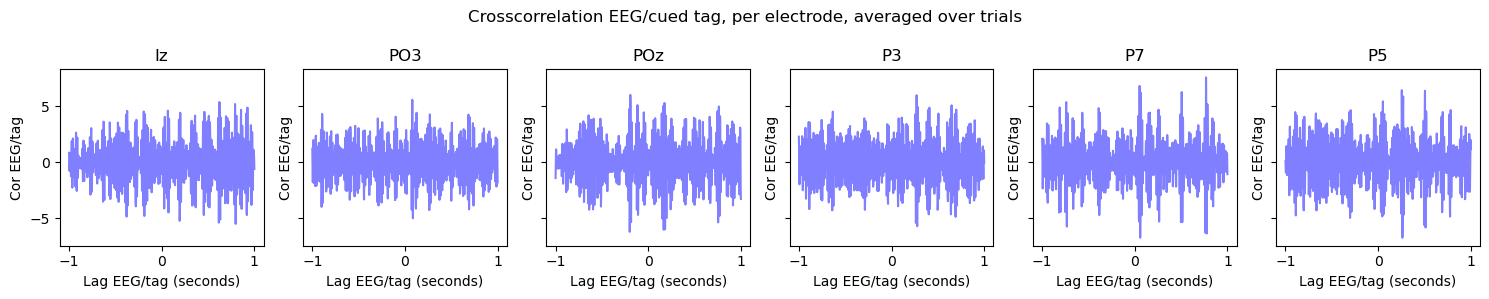

In [11]:
fig, ax = plt.subplots(1,len(freqtag_electrodes), figsize=(15, 3), sharey=True, sharex=True)
for e, elec in enumerate(freqtag_electrodes):
    ax[e].plot(times, cor_with_cued[:, e, :].mean(axis=0).T, color='blue', alpha=0.5)
    ax[e].set_title(elec)
    ax[e].set_xlabel('Lag EEG/tag (seconds)')
    ax[e].set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/cued tag, per electrode, averaged over trials')
plt.tight_layout()
plt.show()


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_13926/1178954655.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


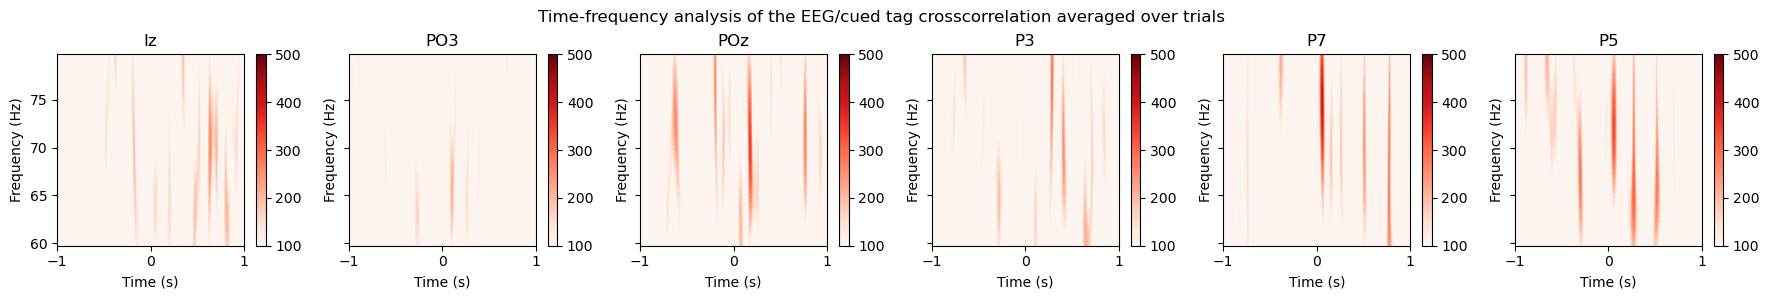

In [12]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().pick(freqtag_electrodes).crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).resample(sfreq)
# Do the time frequency analysis
tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
# Store in MNE format
tfr = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([tfr[:,:,:,:].mean(axis=0)]), epochs_noistag_cropped.times, freqs)

# Plot
fig, axes = plt.subplots(1, len(freqtag_electrodes), figsize=(18, 3), sharey = True) 
axes = axes.flatten() 
channels = epochs_noistag_cropped.info['ch_names']
for e, (channel, ax) in enumerate(zip(channels, axes)):
    tfr.plot(
        [channel],
        baseline=(None,0),
        vlim=(100, 500),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
plt.tight_layout()
plt.suptitle('Time-frequency analysis of the EEG/cued tag crosscorrelation averaged over trials')
plt.show()



### 1.1 Comparing mean pre vs post cue

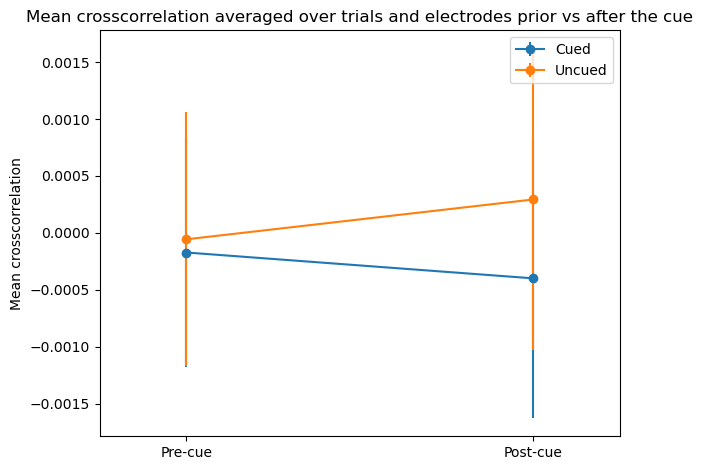

In [13]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].mean(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].mean(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].mean(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].mean(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Mean crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Mean crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 1.2 Comparing mean cross-correlation on displayed trial vs others

In [14]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

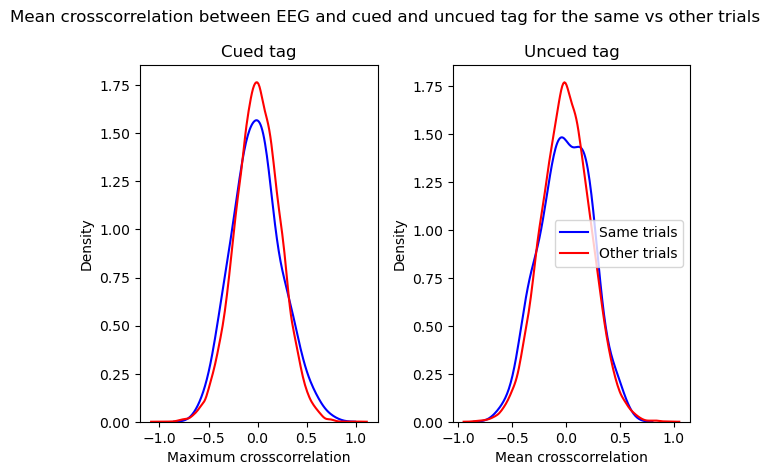

In [15]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the mean for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).mean(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).mean(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the mean for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).mean(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).mean(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Mean crosscorrelation')
plt.suptitle('Mean crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### 1.3 Comparing max cross-correlation pre vs post cue

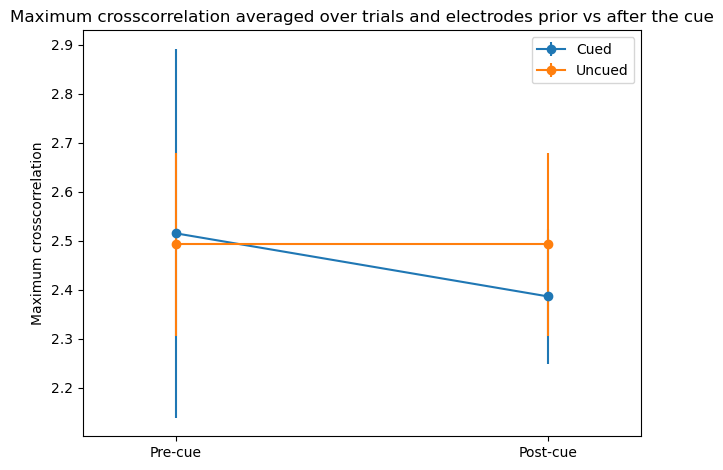

In [16]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 1.4 Comparing max cross-correlation on displayed trial vs others

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

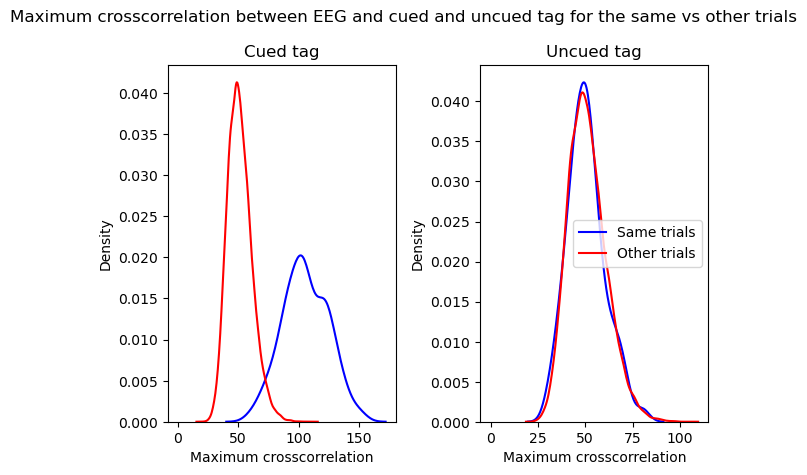

In [17]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

# 1% noise

In [18]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 451 samples (0.220 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s


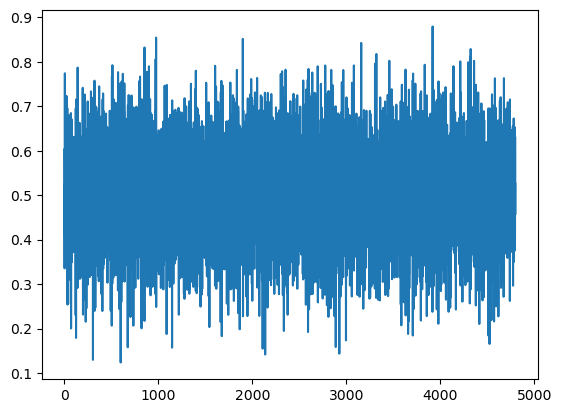

In [19]:
# First noise tag at block 15 trial 32
plt.plot((noise_stims[14,31,0,:].T+noise_stims[14,31,1,:].T)/2)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [20]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [21]:
noise_stims_tr.shape

(480, 2, 4800)

### Inject cued tags to EEG

In [22]:
epochs_noistag.resample(480)
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']) :
    offset = int(np.random.normal(.2, .025)*epochs_noistag.info['sfreq'])#np.random.randint(int(.1*epochs_noistag.info['sfreq']), int(.125*epochs_noistag.info['sfreq']))
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Select the tag that was projected during the trial
    injected_tag = noise_stims_tr[trial, cued_side, \
        :int((np.abs(epochs_noistag.tmax))*epochs_noistag.info['sfreq'])-offset+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.01010101
    # Add the tag to the EEG
    buffer_arr[idx,:,int((np.abs(epochs_noistag.tmin))*epochs_noistag.info['sfreq'])+offset:] += injected_tag
epochs_noistag._data = buffer_arr


/tmp/ipykernel_13926/2380883170.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_13926/2380883170.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


### Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.


Text(0, 0.5, 'Cor EEG/tag')

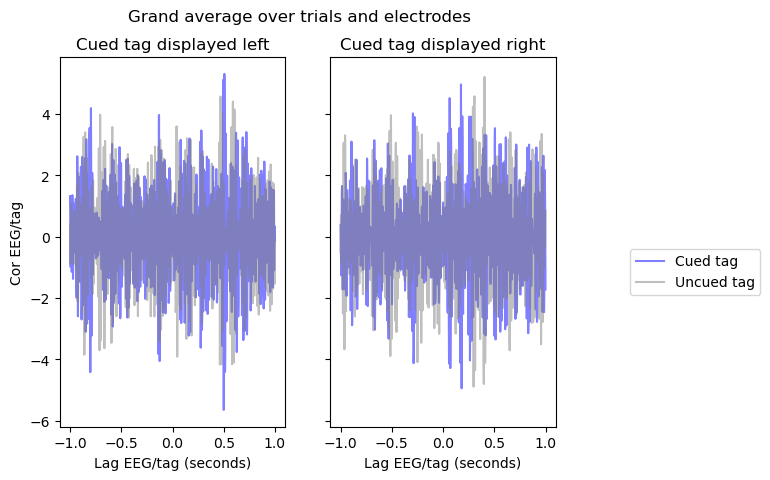

In [23]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

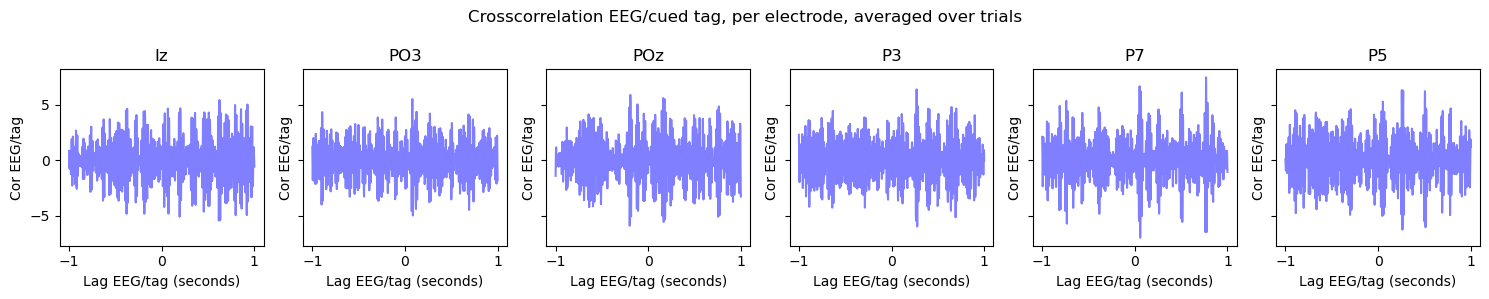

In [24]:
fig, ax = plt.subplots(1,len(freqtag_electrodes), figsize=(15, 3), sharey=True, sharex=True)
for e, elec in enumerate(freqtag_electrodes):
    ax[e].plot(times, cor_with_cued[:, e, :].mean(axis=0).T, color='blue', alpha=0.5)
    ax[e].set_title(elec)
    ax[e].set_xlabel('Lag EEG/tag (seconds)')
    ax[e].set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/cued tag, per electrode, averaged over trials')
plt.tight_layout()
plt.show()


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_13926/1178954655.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


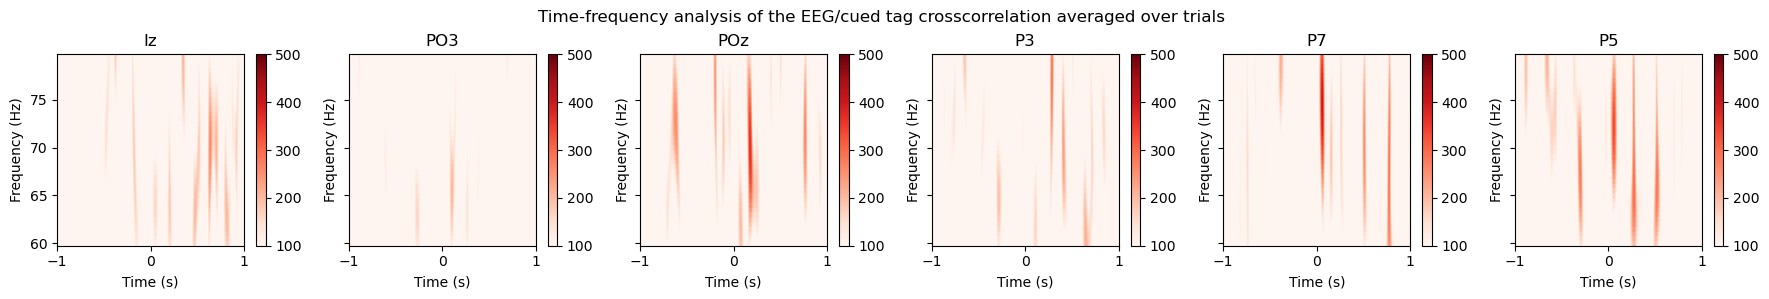

In [25]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().pick(freqtag_electrodes).crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).resample(sfreq)
# Do the time frequency analysis
tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
# Store in MNE format
tfr = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([tfr[:,:,:,:].mean(axis=0)]), epochs_noistag_cropped.times, freqs)

# Plot
fig, axes = plt.subplots(1, len(freqtag_electrodes), figsize=(18, 3), sharey = True) 
axes = axes.flatten() 
channels = epochs_noistag_cropped.info['ch_names']
for e, (channel, ax) in enumerate(zip(channels, axes)):
    tfr.plot(
        [channel],
        baseline=(None,0),
        vlim=(100, 500),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
plt.tight_layout()
plt.suptitle('Time-frequency analysis of the EEG/cued tag crosscorrelation averaged over trials')
plt.show()



### 2.1 Comparing mean pre vs post cue

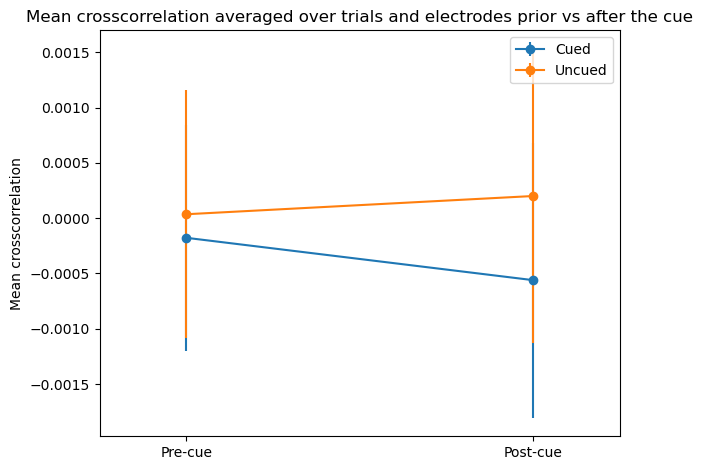

In [26]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].mean(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].mean(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].mean(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].mean(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Mean crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Mean crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 2.2 Comparing mean cross-correlation on displayed trial vs others

In [27]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the instance is already 480.0, returning unmodified.
Sampling frequency of the

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

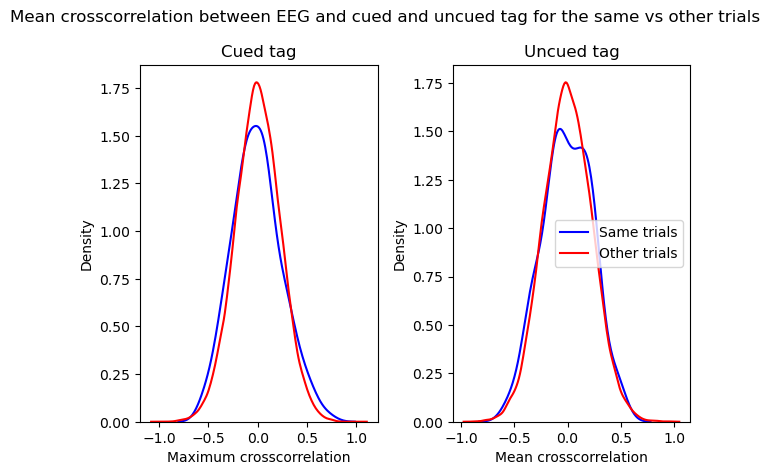

In [28]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the mean for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).mean(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).mean(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the mean for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).mean(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).mean(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Mean crosscorrelation')
plt.suptitle('Mean crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### 2.3 Comparing max cross-correlation pre vs post cue

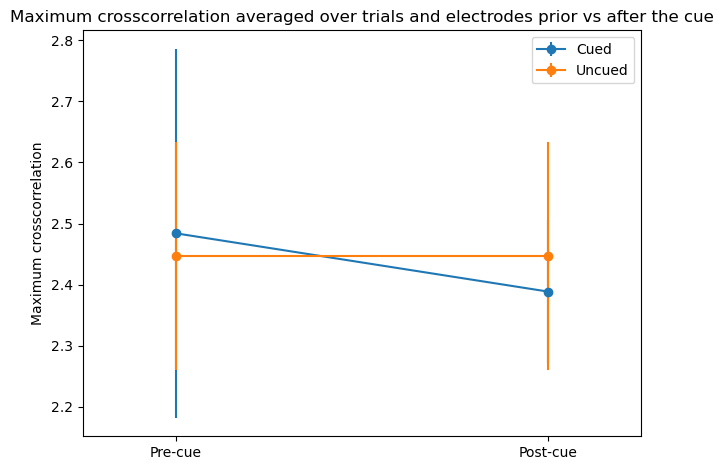

In [29]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

### 2.4 Comparing max cross-correlation on displayed trial vs others

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

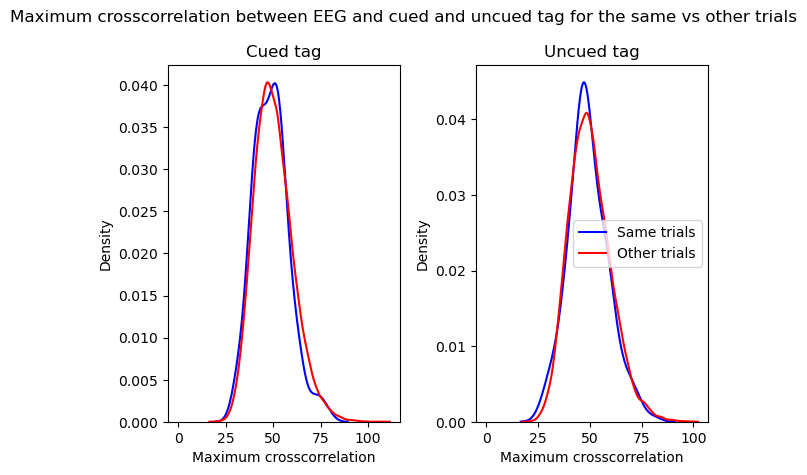

In [30]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()